In [2]:
import keras
import json
from keras import regularizers
import numpy as np
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop, Adam
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential, Input
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from keras.layers import LSTM, Bidirectional, Activation, CuDNNLSTM, Layer
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers

import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

Using TensorFlow backend.


In [3]:
import keras.backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
tqdm.monitor_interval = 0
#hyperparamter
DATA_DIR = "../data/"
output_dir = '../data/lstm_attn2/'

#data
test_size = 0.1
validation_size = 0.1
random_state = 12345

#Training 
epochs = 20
batch_size = 128

#vector-space embedding
n_dim = 64
n_unique_words = 10000
max_length = 100
pad_type = trunc_type = 'pre' # 'pre' or 'post'
drop_embed = 0.25
trainable = False

#lstm architecture 
n_lstm = 64
drop_lstm = 0.1
kernel_reg_lstm = 0.000014
activity_reg_lstm = 0.000012

#fully connected layer 
n_fc = 64
kernel_reg_fc = 0.000013
drop_fc = 0.1

#optimizer 
learning_rate = 0.0007


In [15]:
# load the data
with open('../data/data.pkl','rb') as f:
    data = pickle.load(f)
with open('../data/labels.pkl','rb') as f:
    labels = pickle.load(f)

In [19]:
# change of lables
FILE_SIM = '../data/even_distribution_freq.json'
with open(FILE_SIM) as f:
    sim = json.load(f)
rev_sim = dict()
for k,v in sim.items():
    for x in v:
        if x in rev_sim:
            rev_sim[x].append(k)
        else:
            rev_sim[x] = [k]
temp = []
for l in labels:
    s = set()
    for x in l:
        if x in rev_sim:
            for y in rev_sim[x]:
                s.add(y)
        else:
            s.add(x)
    temp.append(list(s))
# labels = temp

In [21]:
labels = temp

In [22]:
# with open('../data/data.pkl','wb') as f:
#     pickle.dump(data,f)
# with open('../data/labels.pkl','wb') as f:
#     pickle.dump(labels,f)

In [23]:
len(data)

51915

In [24]:
one_hot = MultiLabelBinarizer()
labels = one_hot.fit_transform(labels)
len(labels[0])

45

In [25]:
data = np.array(data)
labels = np.array(labels)


In [26]:
train_x,test_x, train_y, test_y = train_test_split(data, labels, test_size=test_size, random_state=random_state)

In [27]:
len(train_x), len(train_y), len(test_x), len(test_y)

(46723, 46723, 5192, 5192)

In [28]:
train_y = [x for x in train_y.transpose()]
test_y = [x for x in test_y.transpose()]

In [29]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [30]:
tok_1 = Tokenizer(num_words=n_unique_words)
tok_1.fit_on_texts(train_x)                                
sequences = tok_1.texts_to_sequences(train_x)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

In [31]:
EMBEDDING_FILE = '../data/embeddings/glove.840B.300d/glove.840B.300d.txt'
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

In [32]:
word_index = tok_1.word_index
nb_words = min(n_unique_words, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in tqdm(word_index.items()):
    if i >= n_unique_words: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

100%|██████████| 93515/93515 [00:00<00:00, 1310330.29it/s]


In [33]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [34]:
def RNN_1():
    inputs = Input(name='inputs', shape=[max_length])
    layer = Embedding(n_unique_words, 
                      300, 
                      #input_length=max_length, 
                      weights=[embedding_matrix], 
                      trainable=trainable
                     )(inputs)  
    layer = SpatialDropout1D(drop_embed)(layer)
    layer = Bidirectional(CuDNNLSTM(n_lstm, 
#                                kernel_regularizer=regularizers.l2(kernel_reg_lstm),
#                                activity_regularizer=regularizers.l1(activity_reg_lstm),
                            return_sequences=True)
                         )(layer)
    
    layer = Attention(max_length)(layer)
    layer_lst=[]
    sigmoid_lst=[]
    for i in range(len(train_y)):
        fc1 = Dense(n_fc,
                    name='FC_1_'+str(i),
                    activation="relu"
                   )(layer)
        fc1 = Dropout(drop_fc)(fc1)
        fc2 = Dense(1,
                    name='FC_2_'+str(i)
                   )(fc1)
        sigmoid_lst.append(Activation('sigmoid')(fc2))

    model = Model(inputs=inputs, outputs=sigmoid_lst)
    return model
model = RNN_1()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     3000000     inputs[0][0]                     
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     187392      spatial_dropout1d_1[0][0]        
__________________________________________________________________________________________________
attention_

In [35]:
model.compile(loss='binary_crossentropy',optimizer=Adam(lr=learning_rate),metrics=['accuracy'])
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5", save_best_only=True)
history = model.fit(sequences_matrix,
          train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=validation_size, 
          callbacks=[modelcheckpoint])

Train on 42050 samples, validate on 4673 samples
Epoch 1/20
42050/42050 [==============================] - 71s 2ms/step - loss: 6.4331 - activation_1_loss: 0.1053 - activation_2_loss: 0.0946 - activation_3_loss: 0.0517 - activation_4_loss: 0.1265 - activation_5_loss: 0.1317 - activation_6_loss: 0.1236 - activation_7_loss: 0.3191 - activation_8_loss: 0.3791 - activation_9_loss: 0.0910 - activation_10_loss: 0.1158 - activation_11_loss: 0.1841 - activation_12_loss: 0.4131 - activation_13_loss: 0.1437 - activation_14_loss: 0.1017 - activation_15_loss: 0.1029 - activation_16_loss: 0.0962 - activation_17_loss: 0.0566 - activation_18_loss: 0.0576 - activation_19_loss: 0.1683 - activation_20_loss: 0.1431 - activation_21_loss: 0.0342 - activation_22_loss: 0.0453 - activation_23_loss: 0.0696 - activation_24_loss: 0.0386 - activation_25_loss: 0.2332 - activation_26_loss: 0.2753 - activation_27_loss: 0.0762 - activation_28_loss: 0.0467 - activation_29_loss: 0.3526 - activation_30_loss: 0.3575 - ac

42050/42050 [==============================] - 44s 1ms/step - loss: 4.8828 - activation_1_loss: 0.0881 - activation_2_loss: 0.0734 - activation_3_loss: 0.0311 - activation_4_loss: 0.1011 - activation_5_loss: 0.1126 - activation_6_loss: 0.1024 - activation_7_loss: 0.2622 - activation_8_loss: 0.3548 - activation_9_loss: 0.0692 - activation_10_loss: 0.0888 - activation_11_loss: 0.1655 - activation_12_loss: 0.2305 - activation_13_loss: 0.0976 - activation_14_loss: 0.0826 - activation_15_loss: 0.0720 - activation_16_loss: 0.0731 - activation_17_loss: 0.0367 - activation_18_loss: 0.0457 - activation_19_loss: 0.1074 - activation_20_loss: 0.1153 - activation_21_loss: 0.0170 - activation_22_loss: 0.0161 - activation_23_loss: 0.0513 - activation_24_loss: 0.0210 - activation_25_loss: 0.1535 - activation_26_loss: 0.2111 - activation_27_loss: 0.0529 - activation_28_loss: 0.0184 - activation_29_loss: 0.2618 - activation_30_loss: 0.2693 - activation_31_loss: 0.0172 - activation_32_loss: 0.0368 - acti

Epoch 4/20
42050/42050 [==============================] - 44s 1ms/step - loss: 4.2388 - activation_1_loss: 0.0830 - activation_2_loss: 0.0702 - activation_3_loss: 0.0293 - activation_4_loss: 0.0653 - activation_5_loss: 0.1010 - activation_6_loss: 0.0719 - activation_7_loss: 0.2409 - activation_8_loss: 0.3375 - activation_9_loss: 0.0560 - activation_10_loss: 0.0767 - activation_11_loss: 0.1523 - activation_12_loss: 0.2022 - activation_13_loss: 0.0798 - activation_14_loss: 0.0778 - activation_15_loss: 0.0510 - activation_16_loss: 0.0428 - activation_17_loss: 0.0328 - activation_18_loss: 0.0375 - activation_19_loss: 0.0812 - activation_20_loss: 0.0865 - activation_21_loss: 0.0162 - activation_22_loss: 0.0147 - activation_23_loss: 0.0462 - activation_24_loss: 0.0194 - activation_25_loss: 0.1115 - activation_26_loss: 0.1838 - activation_27_loss: 0.0350 - activation_28_loss: 0.0172 - activation_29_loss: 0.2204 - activation_30_loss: 0.2277 - activation_31_loss: 0.0160 - activation_32_loss: 0.

Epoch 6/20
42050/42050 [==============================] - 43s 1ms/step - loss: 4.0147 - activation_1_loss: 0.0807 - activation_2_loss: 0.0679 - activation_3_loss: 0.0281 - activation_4_loss: 0.0516 - activation_5_loss: 0.0927 - activation_6_loss: 0.0627 - activation_7_loss: 0.2334 - activation_8_loss: 0.3329 - activation_9_loss: 0.0463 - activation_10_loss: 0.0736 - activation_11_loss: 0.1463 - activation_12_loss: 0.1931 - activation_13_loss: 0.0755 - activation_14_loss: 0.0750 - activation_15_loss: 0.0431 - activation_16_loss: 0.0351 - activation_17_loss: 0.0307 - activation_18_loss: 0.0341 - activation_19_loss: 0.0751 - activation_20_loss: 0.0793 - activation_21_loss: 0.0159 - activation_22_loss: 0.0139 - activation_23_loss: 0.0413 - activation_24_loss: 0.0190 - activation_25_loss: 0.1008 - activation_26_loss: 0.1759 - activation_27_loss: 0.0309 - activation_28_loss: 0.0163 - activation_29_loss: 0.2077 - activation_30_loss: 0.2162 - activation_31_loss: 0.0155 - activation_32_loss: 0.

Epoch 8/20
42050/42050 [==============================] - 45s 1ms/step - loss: 3.8866 - activation_1_loss: 0.0794 - activation_2_loss: 0.0670 - activation_3_loss: 0.0274 - activation_4_loss: 0.0453 - activation_5_loss: 0.0903 - activation_6_loss: 0.0594 - activation_7_loss: 0.2271 - activation_8_loss: 0.3286 - activation_9_loss: 0.0411 - activation_10_loss: 0.0722 - activation_11_loss: 0.1427 - activation_12_loss: 0.1862 - activation_13_loss: 0.0724 - activation_14_loss: 0.0736 - activation_15_loss: 0.0411 - activation_16_loss: 0.0314 - activation_17_loss: 0.0286 - activation_18_loss: 0.0316 - activation_19_loss: 0.0725 - activation_20_loss: 0.0766 - activation_21_loss: 0.0151 - activation_22_loss: 0.0130 - activation_23_loss: 0.0385 - activation_24_loss: 0.0184 - activation_25_loss: 0.0946 - activation_26_loss: 0.1709 - activation_27_loss: 0.0289 - activation_28_loss: 0.0153 - activation_29_loss: 0.2007 - activation_30_loss: 0.2087 - activation_31_loss: 0.0153 - activation_32_loss: 0.

Epoch 10/20
42050/42050 [==============================] - 45s 1ms/step - loss: 3.7907 - activation_1_loss: 0.0787 - activation_2_loss: 0.0648 - activation_3_loss: 0.0262 - activation_4_loss: 0.0424 - activation_5_loss: 0.0876 - activation_6_loss: 0.0555 - activation_7_loss: 0.2227 - activation_8_loss: 0.3265 - activation_9_loss: 0.0386 - activation_10_loss: 0.0700 - activation_11_loss: 0.1399 - activation_12_loss: 0.1814 - activation_13_loss: 0.0695 - activation_14_loss: 0.0717 - activation_15_loss: 0.0392 - activation_16_loss: 0.0304 - activation_17_loss: 0.0259 - activation_18_loss: 0.0303 - activation_19_loss: 0.0694 - activation_20_loss: 0.0736 - activation_21_loss: 0.0144 - activation_22_loss: 0.0126 - activation_23_loss: 0.0361 - activation_24_loss: 0.0180 - activation_25_loss: 0.0909 - activation_26_loss: 0.1664 - activation_27_loss: 0.0283 - activation_28_loss: 0.0148 - activation_29_loss: 0.1950 - activation_30_loss: 0.2051 - activation_31_loss: 0.0149 - activation_32_loss: 0

42050/42050 [==============================] - 48s 1ms/step - loss: 3.7572 - activation_1_loss: 0.0782 - activation_2_loss: 0.0646 - activation_3_loss: 0.0262 - activation_4_loss: 0.0413 - activation_5_loss: 0.0860 - activation_6_loss: 0.0546 - activation_7_loss: 0.2217 - activation_8_loss: 0.3245 - activation_9_loss: 0.0371 - activation_10_loss: 0.0700 - activation_11_loss: 0.1392 - activation_12_loss: 0.1804 - activation_13_loss: 0.0694 - activation_14_loss: 0.0712 - activation_15_loss: 0.0387 - activation_16_loss: 0.0287 - activation_17_loss: 0.0250 - activation_18_loss: 0.0297 - activation_19_loss: 0.0694 - activation_20_loss: 0.0729 - activation_21_loss: 0.0139 - activation_22_loss: 0.0122 - activation_23_loss: 0.0355 - activation_24_loss: 0.0179 - activation_25_loss: 0.0902 - activation_26_loss: 0.1654 - activation_27_loss: 0.0278 - activation_28_loss: 0.0144 - activation_29_loss: 0.1923 - activation_30_loss: 0.2038 - activation_31_loss: 0.0145 - activation_32_loss: 0.0270 - acti

Epoch 13/20
42050/42050 [==============================] - 48s 1ms/step - loss: 3.6829 - activation_1_loss: 0.0767 - activation_2_loss: 0.0629 - activation_3_loss: 0.0257 - activation_4_loss: 0.0393 - activation_5_loss: 0.0853 - activation_6_loss: 0.0527 - activation_7_loss: 0.2182 - activation_8_loss: 0.3211 - activation_9_loss: 0.0355 - activation_10_loss: 0.0688 - activation_11_loss: 0.1370 - activation_12_loss: 0.1764 - activation_13_loss: 0.0664 - activation_14_loss: 0.0694 - activation_15_loss: 0.0377 - activation_16_loss: 0.0272 - activation_17_loss: 0.0236 - activation_18_loss: 0.0282 - activation_19_loss: 0.0665 - activation_20_loss: 0.0715 - activation_21_loss: 0.0137 - activation_22_loss: 0.0121 - activation_23_loss: 0.0344 - activation_24_loss: 0.0178 - activation_25_loss: 0.0870 - activation_26_loss: 0.1615 - activation_27_loss: 0.0271 - activation_28_loss: 0.0138 - activation_29_loss: 0.1889 - activation_30_loss: 0.1993 - activation_31_loss: 0.0140 - activation_32_loss: 0

Epoch 15/20
42050/42050 [==============================] - 48s 1ms/step - loss: 3.6258 - activation_1_loss: 0.0770 - activation_2_loss: 0.0611 - activation_3_loss: 0.0250 - activation_4_loss: 0.0380 - activation_5_loss: 0.0829 - activation_6_loss: 0.0524 - activation_7_loss: 0.2159 - activation_8_loss: 0.3193 - activation_9_loss: 0.0344 - activation_10_loss: 0.0673 - activation_11_loss: 0.1356 - activation_12_loss: 0.1728 - activation_13_loss: 0.0642 - activation_14_loss: 0.0680 - activation_15_loss: 0.0368 - activation_16_loss: 0.0264 - activation_17_loss: 0.0219 - activation_18_loss: 0.0274 - activation_19_loss: 0.0653 - activation_20_loss: 0.0695 - activation_21_loss: 0.0131 - activation_22_loss: 0.0117 - activation_23_loss: 0.0333 - activation_24_loss: 0.0173 - activation_25_loss: 0.0850 - activation_26_loss: 0.1601 - activation_27_loss: 0.0263 - activation_28_loss: 0.0128 - activation_29_loss: 0.1853 - activation_30_loss: 0.1981 - activation_31_loss: 0.0136 - activation_32_loss: 0

Epoch 17/20
42050/42050 [==============================] - 46s 1ms/step - loss: 3.5606 - activation_1_loss: 0.0755 - activation_2_loss: 0.0596 - activation_3_loss: 0.0248 - activation_4_loss: 0.0357 - activation_5_loss: 0.0828 - activation_6_loss: 0.0505 - activation_7_loss: 0.2132 - activation_8_loss: 0.3164 - activation_9_loss: 0.0322 - activation_10_loss: 0.0662 - activation_11_loss: 0.1343 - activation_12_loss: 0.1694 - activation_13_loss: 0.0627 - activation_14_loss: 0.0668 - activation_15_loss: 0.0357 - activation_16_loss: 0.0256 - activation_17_loss: 0.0212 - activation_18_loss: 0.0259 - activation_19_loss: 0.0633 - activation_20_loss: 0.0687 - activation_21_loss: 0.0128 - activation_22_loss: 0.0112 - activation_23_loss: 0.0320 - activation_24_loss: 0.0170 - activation_25_loss: 0.0827 - activation_26_loss: 0.1570 - activation_27_loss: 0.0259 - activation_28_loss: 0.0118 - activation_29_loss: 0.1833 - activation_30_loss: 0.1943 - activation_31_loss: 0.0130 - activation_32_loss: 0

Epoch 19/20
42050/42050 [==============================] - 48s 1ms/step - loss: 3.5142 - activation_1_loss: 0.0746 - activation_2_loss: 0.0573 - activation_3_loss: 0.0234 - activation_4_loss: 0.0344 - activation_5_loss: 0.0813 - activation_6_loss: 0.0485 - activation_7_loss: 0.2112 - activation_8_loss: 0.3143 - activation_9_loss: 0.0316 - activation_10_loss: 0.0661 - activation_11_loss: 0.1323 - activation_12_loss: 0.1673 - activation_13_loss: 0.0614 - activation_14_loss: 0.0661 - activation_15_loss: 0.0356 - activation_16_loss: 0.0252 - activation_17_loss: 0.0215 - activation_18_loss: 0.0254 - activation_19_loss: 0.0625 - activation_20_loss: 0.0667 - activation_21_loss: 0.0121 - activation_22_loss: 0.0110 - activation_23_loss: 0.0317 - activation_24_loss: 0.0168 - activation_25_loss: 0.0817 - activation_26_loss: 0.1542 - activation_27_loss: 0.0259 - activation_28_loss: 0.0116 - activation_29_loss: 0.1797 - activation_30_loss: 0.1911 - activation_31_loss: 0.0126 - activation_32_loss: 0

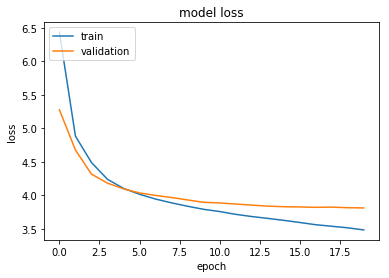

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

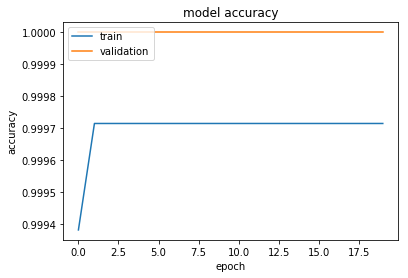

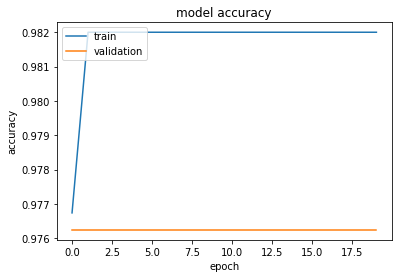

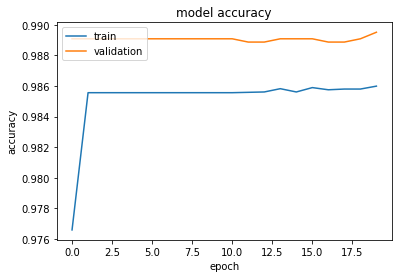

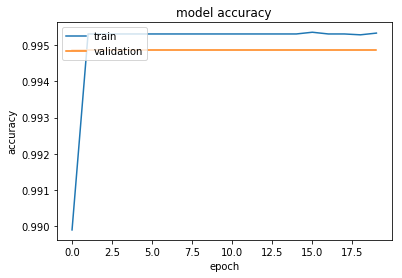

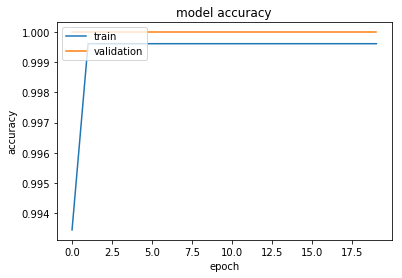

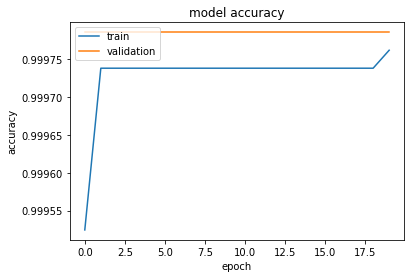

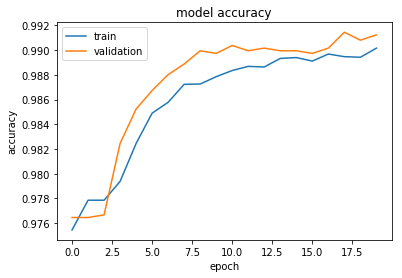

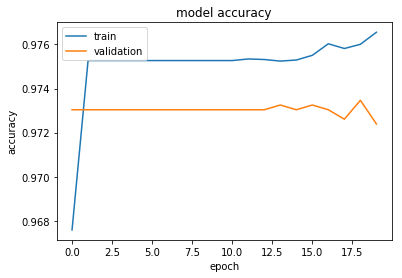

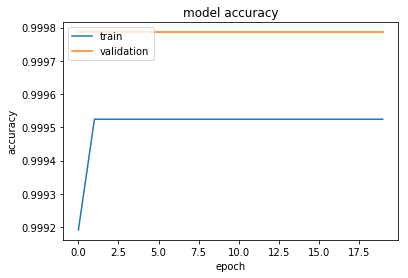

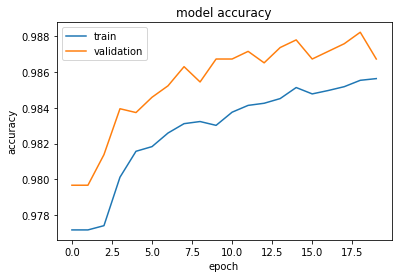

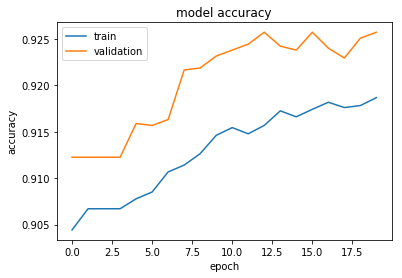

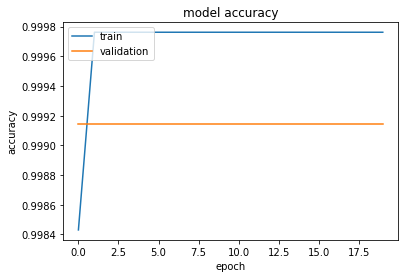

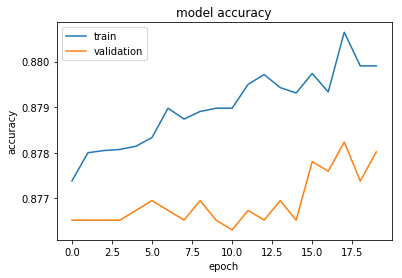

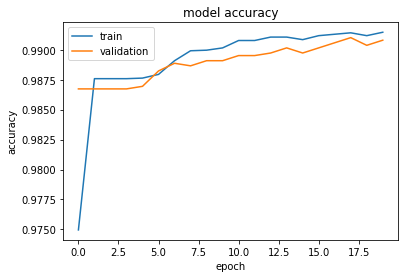

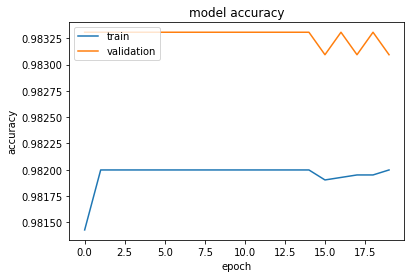

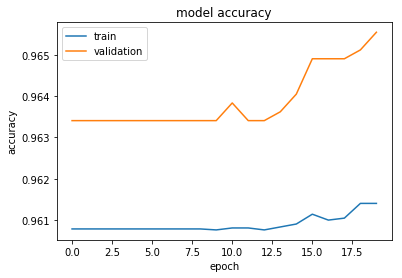

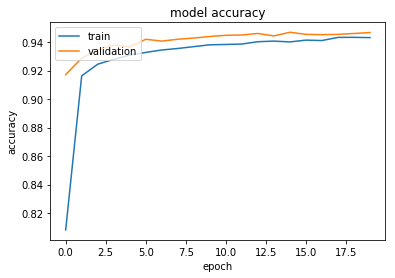

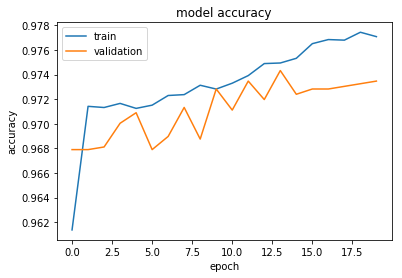

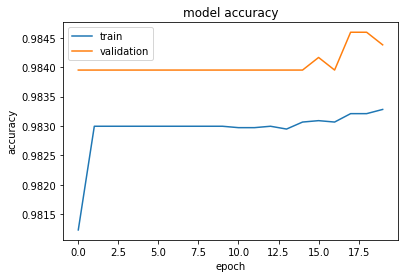

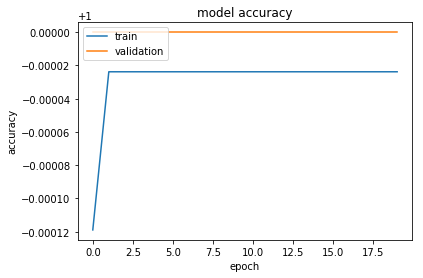

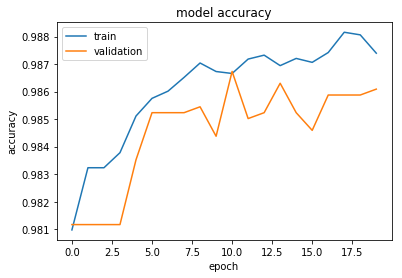

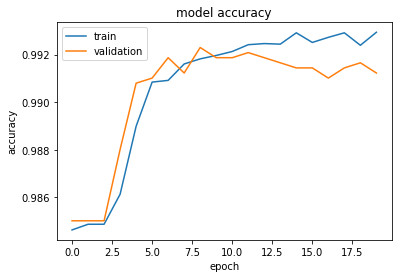

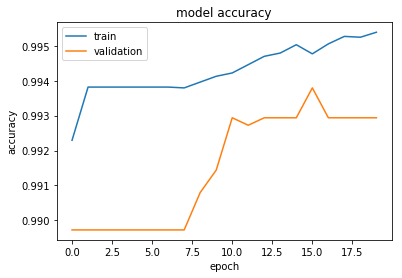

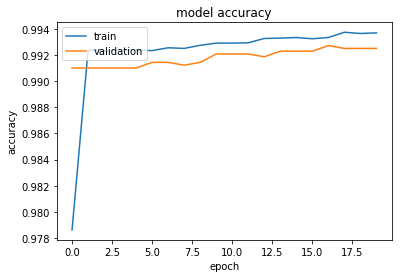

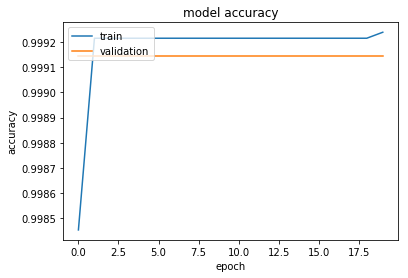

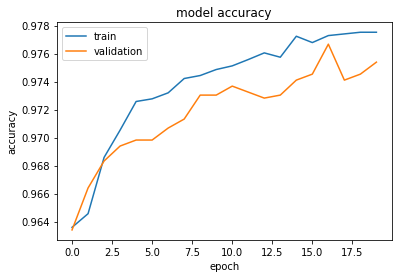

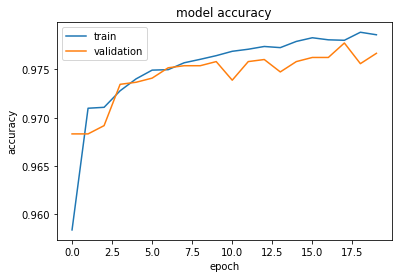

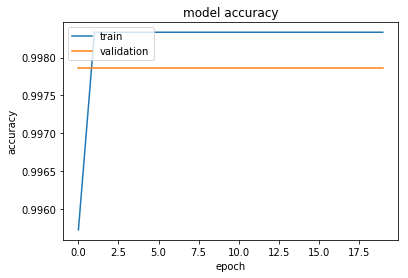

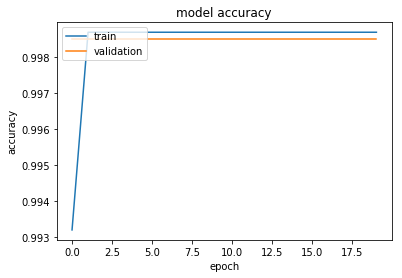

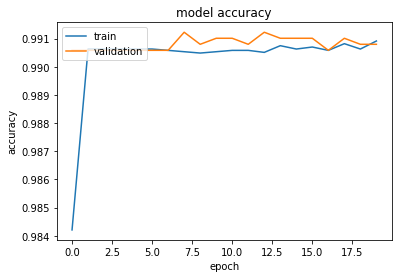

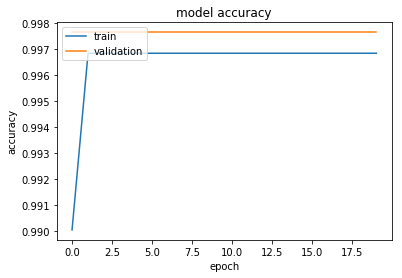

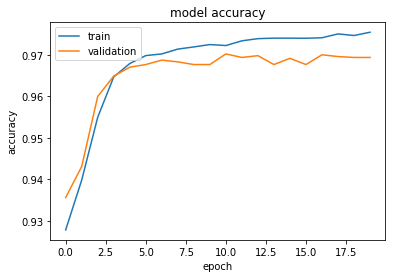

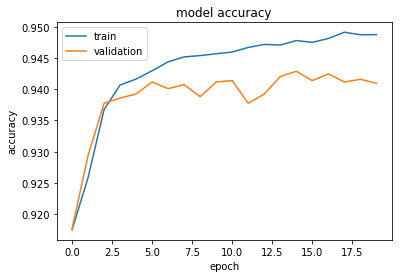

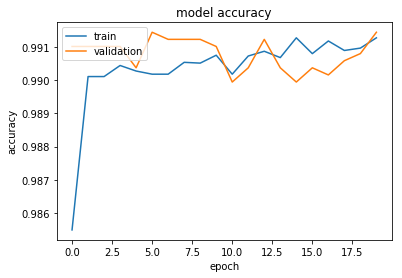

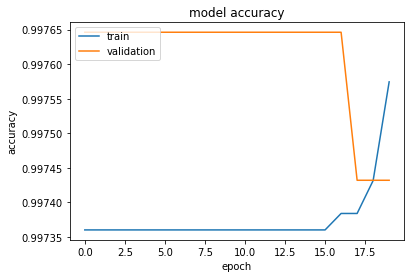

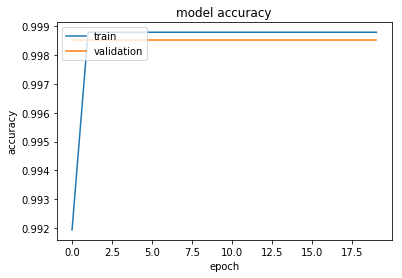

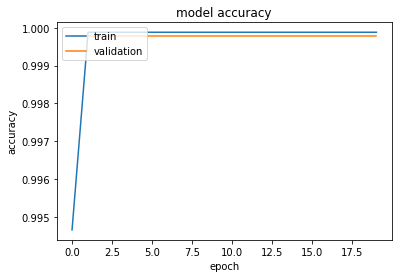

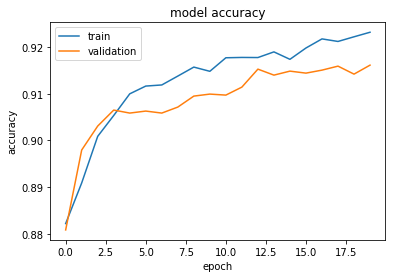

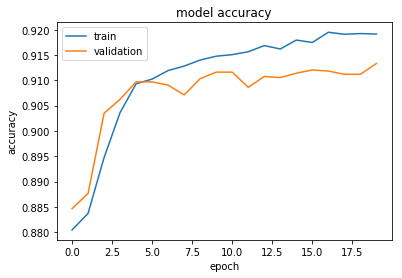

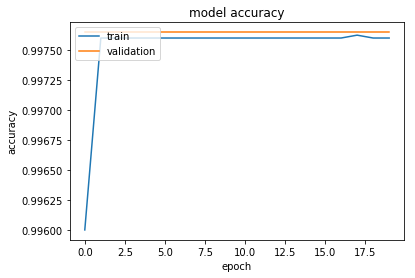

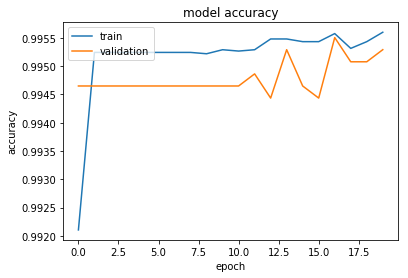

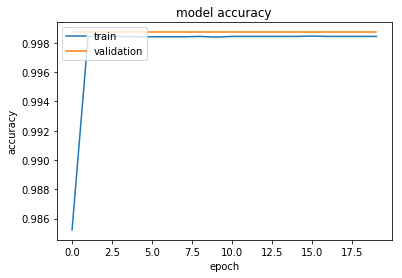

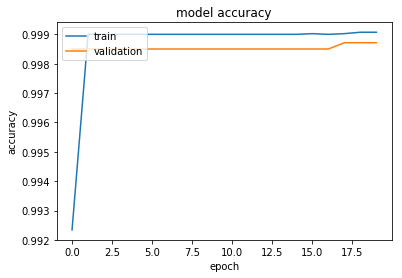

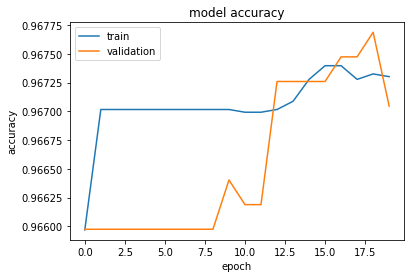

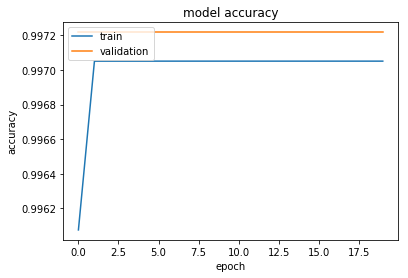

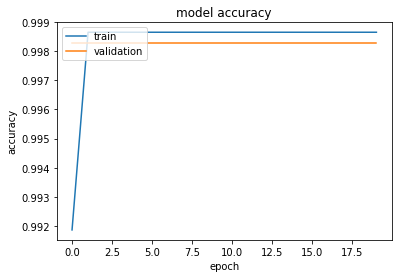

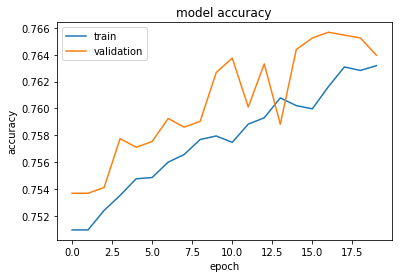

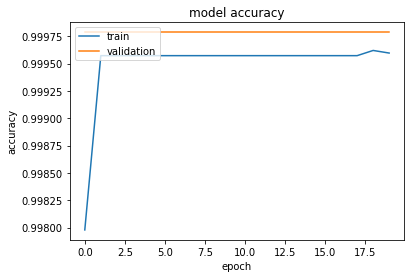

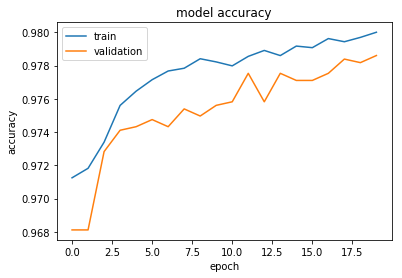

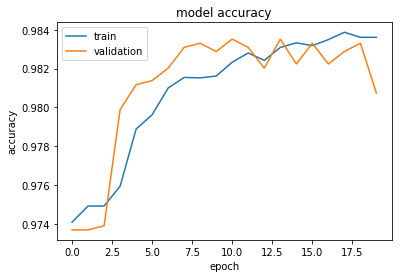

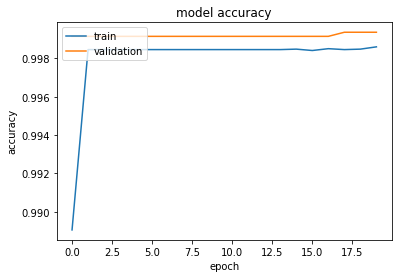

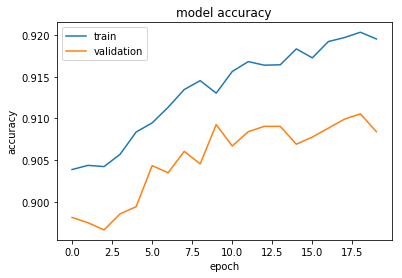

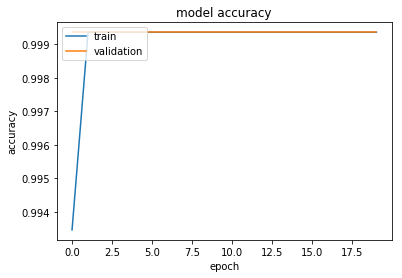

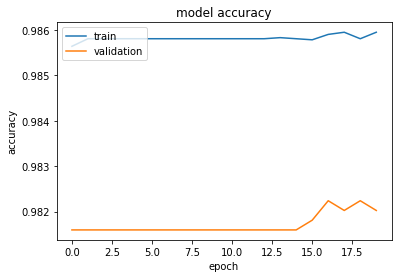

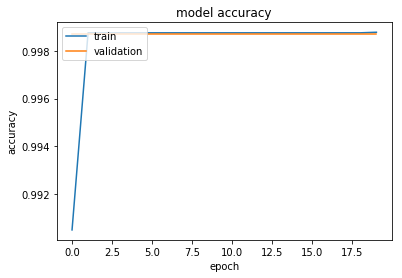

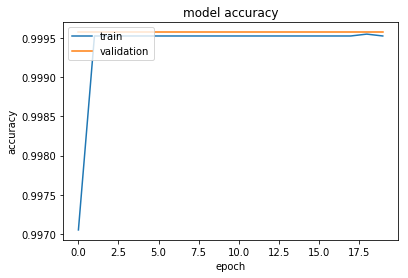

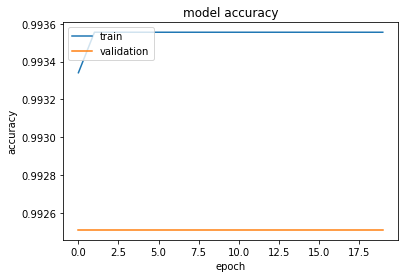

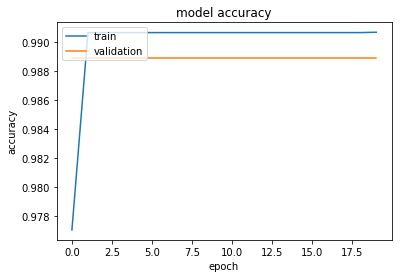

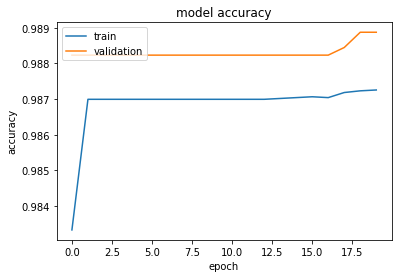

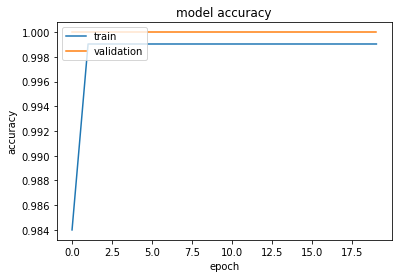

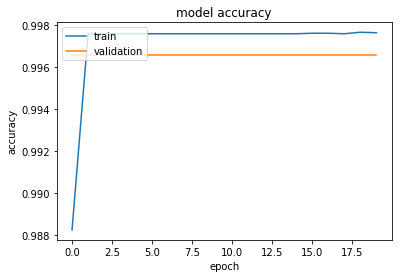

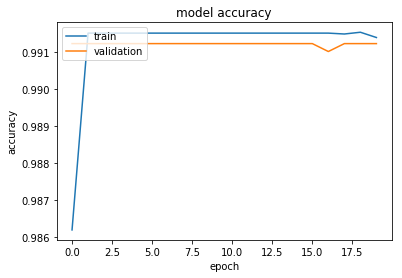

In [23]:
# testing accuracies 
#  "Accuracy"
for i in range(1,63):
    plt.plot(history.history['activation_'+str(i)+'_acc'])
    plt.plot(history.history['val_activation_'+str(i)+'_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [24]:
len(test_x),len(test_y)

(5192, 62)

In [37]:
# Testing
tok_1.fit_on_texts(test_x)                                
sequences = tok_1.texts_to_sequences(test_x)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_length, padding=pad_type, truncating=trunc_type)

In [38]:
pred = model.predict(sequences_matrix,batch_size=128,verbose=1)

5192/5192 [==============================] - 3s 542us/step


In [46]:
z = np.array(pred)
z = np.squeeze(z,axis=2)
z = z.transpose()
print(z[0])
z = z>=0.2
z = z.astype(int)

[1.35365101e-02 5.12416428e-03 2.72035017e-04 1.19473855e-03
 1.58488820e-03 4.39625466e-03 3.72592025e-02 6.16898537e-02
 1.44638366e-03 2.90870480e-03 6.39190851e-03 6.27233505e-01
 1.63262198e-03 2.12253183e-02 2.73202404e-05 9.44400090e-05
 4.24982631e-04 9.51398746e-04 1.35853561e-03 2.28502471e-02
 4.16494487e-03 9.06743750e-04 3.24919034e-04 2.15342245e-03
 3.42296902e-03 8.70802440e-03 1.33045367e-04 3.62612715e-04
 6.29815459e-03 1.28856063e-01 1.05217809e-03 2.07656762e-03
 1.48932938e-03 1.35112349e-02 2.52187485e-04 2.82287002e-01
 2.88395764e-04 7.33265013e-04 2.20219307e-02 7.28951581e-03
 3.98002751e-03 9.89746652e-04 1.31507905e-03 1.20859884e-04
 6.59116684e-03]


In [47]:
z = one_hot.inverse_transform(z)

In [48]:
idx = [23,45,678,234, 543 , 90, 65]
for _id in idx:
    print(test_x[_id],z[_id],"\n\n\n")

The accused persons pleaded not guilty to the charge and their defence, as it appears from the trend of the cross examination and the suggestions put to different prosecution witnesses, was that either she committed suicide or some outsider killed her. The trial court first discussed at length the evidence of the doctor who opined that the death was homicidal and accepting the same held that the defence story that the deceased committed suicide was wholly untenable. It then took up for consideration the question whether any outside could have committed the murder and considering the evidence furnished by the prosecution regarding the topography of the house and the other related circumstances (stated earlier) answered the same in the negative. Coming now to the circumstances relied upon by the prosecution to bring home the charge levelled against the appellant (stated earlier ) we notice that they stand proved by unrebutted evidence and his admissions. Suffice it to say, that considere

In [60]:
for i,x in enumerate(z[:500]):
    print(i,x)

0 ('criminal', 'practice & procedure')
1 ('labour & industrial law',)
2 ('labour & industrial law',)
3 ('arbitration & adr', 'practice & procedure')
4 ()
5 ()
6 ('practice & procedure',)
7 ('criminal',)
8 ('criminal', 'practice & procedure')
9 ('civil procedure', 'land & property', 'practice & procedure')
10 ()
11 ('criminal', 'practice & procedure')
12 ('arbitration & adr',)
13 ('indirect tax',)
14 ('income tax & direct taxes',)
15 ()
16 ()
17 ()
18 ('service',)
19 ('criminal',)
20 ('civil procedure',)
21 ('labour & industrial law', 'service')
22 ('labour & industrial law',)
23 ('income tax & direct taxes',)
24 ('land & property',)
25 ()
26 ('criminal',)
27 ()
28 ()
29 ('land & property', 'practice & procedure')
30 ()
31 ('labour & industrial law',)
32 ()
33 ('labour & industrial law',)
34 ()
35 ('practice & procedure', 'rent control')
36 ()
37 ('indirect tax',)
38 ('criminal',)
39 ('labour & industrial law',)
40 ('practice & procedure',)
41 ()
42 ('service',)
43 ('criminal',)
44 ('se